## Imports

In [182]:
#multi channel CNN for sentiment analysis
import xml.etree.ElementTree as ET
from nltk.corpus import stopwords
from string import punctuation
from os import remove
import pandas as pd
import numpy as np
import re
import fasttext
from random import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from math import sqrt
from gensim.models import KeyedVectors

## Loading data and pre-processing

In [183]:
#loading data
def load_data_from_xml(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    sentences = list()
    score= list()
    for row in root:
        score.append(float(row[1].text))
        sentences.append(row[2].text)
    return sentences,score

In [184]:
sentences,score = load_data_from_xml('dataset/financial_posts_ABSA_train.xml')

In [185]:
# turn a sentence into clean tokens
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
    #removing stock names to see if it helps
    sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [186]:
# extract sentences out of df and cleaning it
sentences = [clean_sentence(x) for x in sentences]
# sentences

In [187]:
#converting real number scores to lables
#0-->-ve sentiment 1-->+ve sentiment
labels = [1 if x >= 0 else 0 for x in score]

In [188]:
def shuffle_data(sentences,labels,score):
    numbers = [i for i in range(len(sentences))]
    shuffle(numbers)
    temp_text = sentences
    temp_lables = labels
    temp_score = score
    for i in numbers:
        sentences[i] = temp_text[i]
        labels[i]=temp_lables[i]
        score[i] = temp_score[i]
    print(len(sentences))
    print(len(labels))
    print(len(score))
    return sentences,labels,score

In [189]:
sentences,labels,score = shuffle_data(sentences,labels,score)

675
675
675


In [190]:
#doing train and train split
test_train_split_ratio =0.9
trainX,testX = sentences[:int(test_train_split_ratio*len(sentences))],sentences[int(test_train_split_ratio*len(sentences)):]
trainY,testY = labels[:int(test_train_split_ratio*len(labels))],labels[int(test_train_split_ratio*len(labels)):]
score_trainY,score_testY = score[:int(test_train_split_ratio*len(score))],score[int(test_train_split_ratio*len(score)):]

In [191]:
print(len(trainX),len(trainY),len(score_trainY))
print(len(testX),len(testY),len(score_testY))

607 607 607
68 68 68


In [192]:
# testY[0]

1

In [193]:
#converting output matrix [-ve,+ve]
testY = to_categorical(testY,2)
trainY = to_categorical(trainY,2)
# testY[:7]

In [194]:
# testY[6]

array([1., 0.])

In [195]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [196]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [197]:
# create tokenizer
tokenizer = create_tokenizer(trainX)
# calculate max document length
lengths = [len(s.split()) for s in trainX]
max_length = max(lengths)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainX, max_length)
testX = encode_text(tokenizer, testX, max_length)
print(trainX.shape,testX.shape)

Max document length: 21
Vocabulary size: 2043
(607, 21) (68, 21)


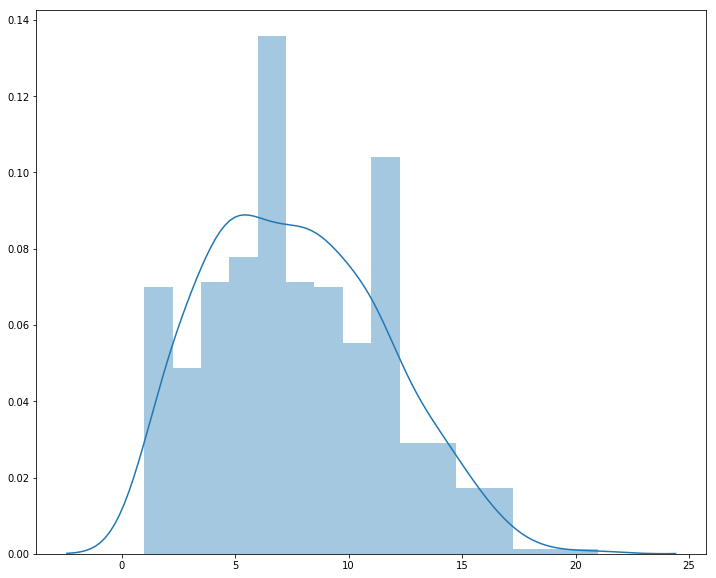

In [198]:
plt.subplots(figsize=(12,10))
sns.distplot(lengths)
# plt.hist(lengths, normed=True,edgecolor='black')

considring only few sentences have len >15, we can also take max_len = 15

## different word embeddings

In [199]:
#loading GloVe embedding
def load_GloVe_embedding(file_name):
    embeddings_index = dict()
    f = open(file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


In [200]:
# create a weight matrix for words in training docs
def get_GloVe_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [201]:
embeddings_index_glove = load_GloVe_embedding('word_embeddings/glove.6B.300d.txt')
embedding_matrix_glove = get_GloVe_embedding_matrix(embeddings_index_glove)
# embedding_matrix[100]
# e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)

Loaded 400000 word vectors.


In [97]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [98]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [100]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)

In [120]:
#fast text word embedding
def get_fast_text_model(sentences):
    try:
        m = fasttext.load_model('fast_text_model.bin')
        print("trained model loaded")
        return m
    except:
        print("traning new model")
        with open('temp_file.txt','w') as temp_file:
            for sentence in sentences:
#                 sentence = sentence.encode('UTF-8')
#                 print(sentence)
                temp_file.write(sentence)
        m = fasttext.cbow('temp_file.txt','fast_text_model')
        remove('temp_file.txt')
        print('model trained')
        return m

In [121]:
def get_fast_text_matrix(model):
    embedding_matrix = np.zeros((vocab_size,100))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [122]:
fast_text_model = get_fast_text_model(trainLines+testLines)
embedding_matrix_fast_text = get_fast_text_matrix(fast_text_model)

traning new model
model trained


## Model

In [202]:
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 300, weights = [embedding_matrix_glove],input_length=length,trainable = False)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 300, weights = [embedding_matrix_word2vec],input_length=length,trainable = False)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 300)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(2, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    print(model.summary())
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [203]:
# define model
model = define_model(max_length, vocab_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 21)           0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 21)           0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 21)           0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 21, 300)      612900      input_19[0][0]                   
__________________________________________________________________________________________________
embedding_

In [204]:
# trainY[606]

In [205]:
# fit model
history_object = model.fit([trainX,trainX,trainX], trainY,epochs=10, batch_size=16)

Epoch 1/10
607/607 [==============================] - 2s 2ms/step - loss: 0.6619 - acc: 0.6227
Epoch 2/10
607/607 [==============================] - 1s 1ms/step - loss: 0.5567 - acc: 0.6755
Epoch 3/10
607/607 [==============================] - 1s 1ms/step - loss: 0.4253 - acc: 0.8122
Epoch 4/10
607/607 [==============================] - 1s 1ms/step - loss: 0.1845 - acc: 0.9506
Epoch 5/10
607/607 [==============================] - 1s 1ms/step - loss: 0.0489 - acc: 0.9819
Epoch 6/10
607/607 [==============================] - 1s 1ms/step - loss: 0.0206 - acc: 0.9967
Epoch 7/10
607/607 [==============================] - 1s 1ms/step - loss: 0.0133 - acc: 0.9967
Epoch 8/10
607/607 [==============================] - 1s 1ms/step - loss: 0.0081 - acc: 1.0000
Epoch 9/10
607/607 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 1.0000
Epoch 10/10
607/607 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.9984


Text(0.5,0,'epoch')

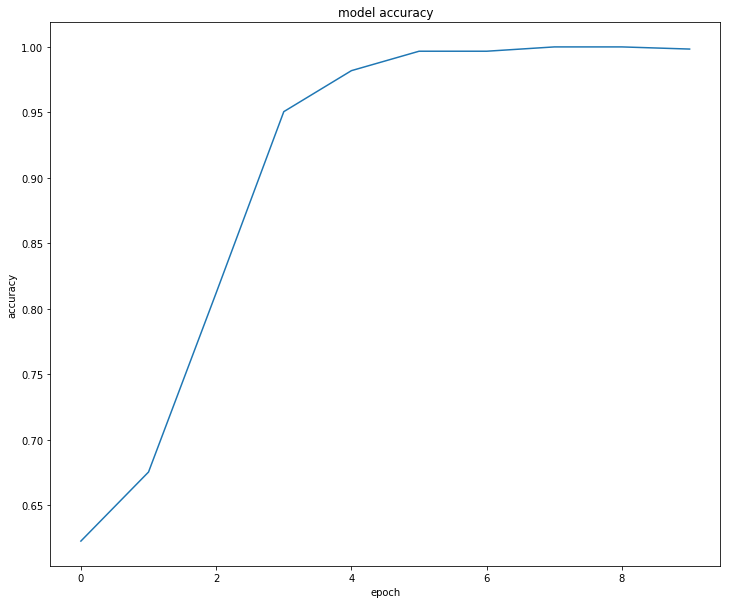

In [206]:
plt.subplots(figsize=(12,10))
plt.plot(history_object.history['acc'])
# plt.plot(history_object.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')

Text(0.5,0,'epoch')

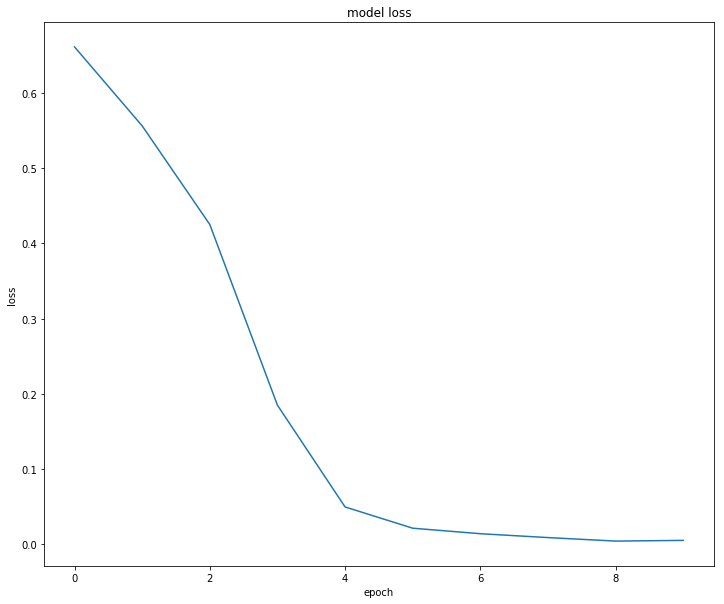

In [207]:
plt.subplots(figsize=(12,10))
plt.plot(history_object.history['loss'])
# plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')

In [208]:
#testing
# encode data
# trainX = encode_text(tokenizer, trainLines, length)


In [209]:
# evaluate model on training dataset
loss, acc = model.evaluate([trainX,trainX,trainX], trainY, verbose=0)
print('Train Accuracy: %f' % (acc*100))
 
# evaluate model on test dataset dataset
loss, acc = model.evaluate([testX,testX,testX], testY, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Train Accuracy: 100.000000
Test Accuracy: 72.058824


In [156]:
# model.predict([testX,testX,testX])

In [157]:
def get_predicted_prob(data):
    return [list(x) for x in model.predict(data)]

In [158]:
#predicted probabilities
train_predicted_prob = get_predicted_prob([trainX,trainX,trainX])
test_predicted_prob = get_predicted_prob([testX,testX,testX])
# predicted_prob

In [159]:
# test_predicted_prob

In [160]:
#predicting lables
#if prob>0.5 -->1 else 0
# def get_predicted_lables(prob):
#     predicted_lables = []
#     for x in prob:
#         if x>0.5:
#             predicted_lables.append(1)
#         else:
#             predicted_lables.append(0)
#     return predicted_lables
def get_predicted_lables(prob):
    predicted_lables = []
    for x in prob:
        if x[0]>x[1]:
            predicted_lables.append(0)
        else:
            predicted_lables.append(1)
    return predicted_lables

In [161]:
train_predicted_lables = get_predicted_lables(train_predicted_prob)
test_predicted_lables = get_predicted_lables(test_predicted_prob)

In [169]:
# train_predicted_lables

In [163]:
# def get_score_from_prob(prob):
#     m = interp1d([0,1],[-1,1])
#     return [float(m(x)) for x in prob]
def get_score_from_prob(prob):
    intensity_score = []
    for x in prob:
        if x[0]>x[1]:
            intensity_score.append(-1*x[0])
        else:
            intensity_score.append(x[1])
    return intensity_score

In [164]:
train_predicted_score = get_score_from_prob(train_predicted_prob)
test_predicted_score = get_score_from_prob(test_predicted_prob)

In [165]:
# test_predicted_score

In [166]:
train_rmse = sqrt(mean_squared_error(score_trainY, train_predicted_score))
test_rmse = sqrt(mean_squared_error(score_testY, test_predicted_score))
print("(train rmse,test rmse)=="+str((train_rmse,test_rmse)))

(train rmse,test rmse)==(0.6103788277307511, 0.7985645382354265)


In [167]:
# foo = [x for x in zip(score_testY,test_predicted_score)]
# foo